# Evaluate finetuned model

In [2]:
id2label = {
    1: "pedestrian",  # No object
    2: "car",
}
label2id = {v: k for k, v in id2label.items()}

In [54]:
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation, AutoModelForUniversalSegmentation
from PIL import Image
import requests
import torch

# Load Mask2Former trained on COCO instance segmentation dataset
image_processor = AutoImageProcessor.from_pretrained(
    "facebook/mask2former-swin-large-coco-instance",
    use_fast=True
)
model = AutoModelForUniversalSegmentation.from_pretrained(
    pretrained_model_name_or_path="/home/toukapy/Dokumentuak/Master CV/C5/mcv-c5-team2/week2/Mask2Former/mask2former_kitti_finetuned_horizon_v2_good_loss/checkpoint-1000",
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

image_path = "/home/toukapy/Dokumentuak/Master CV/C5/mcv-c5-team2/data/KITTI_MOTS/training/image_02/val/0016/000080.png"
image = Image.open(image_path)
inputs = image_processor(image, return_tensors="pt")


print("Predicting...")
with torch.no_grad():
    outputs = model(**inputs)
print("Prediction finished")

# Model predicts class_queries_logits of shape '(batch_size, num_queries)'
# and masks_queries_logits of shape '(batch_size, num_queries, height, width)'
class_queries_logits = outputs.class_queries_logits
masks_queries_logits = outputs.masks_queries_logits

print(class_queries_logits)
print(masks_queries_logits)

# Perform post-processing to get instance segmentation map
pred_instance_map = image_processor.post_process_instance_segmentation(
    outputs, threshold=0.05, target_sizes = [(image.height, image.width)]
)[0]



Predicting...
Prediction finished
tensor([[[-1.0832, -2.0235,  3.3001],
         [-1.3102, -2.0674,  3.3880],
         [-0.4899, -1.9941,  3.2630],
         [-1.2406, -2.1590,  3.3097],
         [-1.3317, -1.7221,  3.5195],
         [-1.1240, -1.7693,  3.1177],
         [ 0.0881, -2.1274,  2.6806],
         [-1.1405, -1.8881,  3.3954],
         [-0.4584, -2.5916,  2.8260],
         [-0.7336, -2.2286,  3.1445],
         [-0.8556, -1.6402,  3.2089],
         [ 0.9440, -1.9078,  1.5942],
         [ 0.1804, -2.3061,  2.3798],
         [-1.5346, -1.9429,  3.7298],
         [-0.7364, -1.8428,  2.9282],
         [ 2.2566, -1.8778,  1.0963],
         [-0.3976, -1.8242,  3.2928],
         [-0.1300, -1.9903,  2.1836],
         [-1.0512, -2.2016,  3.5857],
         [-1.3355, -2.2602,  3.6240],
         [-0.9178, -1.9132,  3.0077],
         [-1.0431, -1.9112,  3.2111],
         [ 2.3887, -1.9619,  0.0579],
         [ 0.1898, -1.7595,  2.0546],
         [-1.3162, -1.8737,  3.4768],
         [-1.581

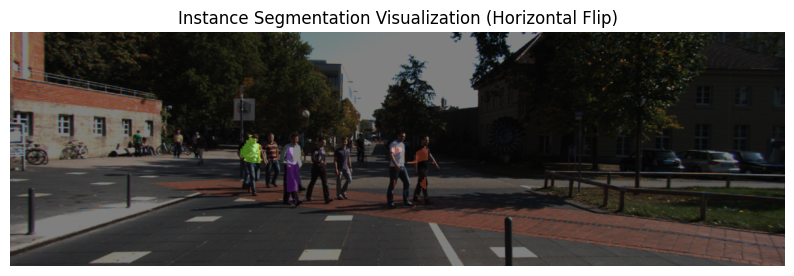

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# Extract the predicted instance segmentation map
instance_map = pred_instance_map["segmentation"].numpy()

# Generate unique colors for each instance
num_instances = int(np.max(instance_map) + 1)  # Number of unique instances
colors = np.random.randint(0, 255, size=(num_instances, 3), dtype=np.uint8)

# Create a colorized mask image
color_mask = np.zeros((*instance_map.shape, 3), dtype=np.float32)
for i in range(1, num_instances):  # Skip background (assumed to be 0)
    color_mask[instance_map == i] = colors[i]

# Convert the original image to numpy
image_np = np.array(image)

# Overlay the mask with some transparency
overlay = (0.5 * image_np + 0.5 * color_mask).astype(np.uint8)

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(overlay)
plt.axis("off")
plt.title("Instance Segmentation Visualization (Horizontal Flip)")
plt.show()

In [22]:
import os
import json
import torch
import numpy as np
from PIL import Image
from torchvision.ops import masks_to_boxes
from torch.utils.data import Dataset, DataLoader
from torchmetrics.detection import MeanAveragePrecision
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation, AutoModelForUniversalSegmentation
from tqdm import tqdm
from torchvision import transforms


# Load Mask2Former trained on COCO instance segmentation dataset
image_processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-large-coco-instance")
model = AutoModelForUniversalSegmentation.from_pretrained(
    "/home/toukapy/Dokumentuak/Master CV/C5/mcv-c5-team2/week2/Mask2Former/mask2former_kitti_finetuned_v2_good_loss/checkpoint-500",
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)
model.eval()

# Define paths
BASE_DIR = "/home/toukapy/Dokumentuak/Master CV/C5/mcv-c5-team2/data/KITTI_MOTS"
image_dir = os.path.join(BASE_DIR, "training/image_02/val")
mask_dir = os.path.join(BASE_DIR, "instances")  # Use preprocessed masks directory
annotation_file = "/home/toukapy/Dokumentuak/Master CV/C5/mcv-c5-team2/data/val_data_kitti_mots_coco.json"

# Load ground truth annotations
with open(annotation_file, "r") as f:
    annotations = json.load(f)

# Define Transform for Images
image_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

COCO_CATEGORY_MAPPING = {
    1: 2,  # KITTI car → COCO car
    2: 1,  # KITTI pedestrian → COCO person
    10: None,  # Ignore class
}

# Define KITTI Dataset
class KITTIDataset(Dataset):
    def __init__(self, annotations, image_dir, mask_dir, transform=None):
        self.annotations = annotations
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform  # Apply transformations if provided

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        ann = self.annotations[idx]
        image_path = os.path.join(self.image_dir, ann["image"])
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)  # Convert to tensor

        gt_boxes, gt_labels, gt_masks = [], [], []
        objs = ann

        for i in range(len(ann["objects"]["id"])):
            mask_path = os.path.join(self.mask_dir, ann["image"])
            if not os.path.exists(mask_path):
                continue
            mask = np.array(Image.open(mask_path)) // 255  # Convert to binary mask

            if mask.sum() == 0:
                continue  # Ignore empty masks

            kitti_class = ann["objects"]["category"][i]
            coco_class = COCO_CATEGORY_MAPPING.get(kitti_class, None)

            if coco_class is None:
                continue  # Ignore class

            gt_masks.append(mask)
            gt_labels.append(coco_class)

        gt_masks = np.array(gt_masks, dtype=bool)  # Shape: (num_objects, H, W)


        return {
        "image": image,  # Now a tensor
        "gt_labels": torch.tensor(gt_labels, dtype=torch.int64),
        "gt_masks": torch.tensor(gt_masks, dtype=torch.bool),
    }

def custom_collate(batch):
    images = [item["image"] for item in batch]
    gt_labels = [item["gt_labels"] for item in batch]
    gt_masks = [item["gt_masks"] for item in batch]  # Keep masks as a list to prevent stacking issues

    return {
        "images": images,  # List of image tensors
        "gt_labels": gt_labels,  # List of label tensors
        "gt_masks": gt_masks,  # List of mask tensors
    }

print("Processing KITTI Dataset")
# Create dataset and dataloader
dataset = KITTIDataset(annotations, image_dir, mask_dir, transform=image_transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=False, num_workers=4, collate_fn=custom_collate)

print("Finished loading KITTI Dataset")

# Perform segmentation predictions and evaluation
# Perform segmentation predictions and evaluation
all_pred_boxes, all_gt_boxes = [], []
for batch in tqdm(dataloader, desc="Processing Batches"):
    images = [item for item in batch["images"]]
    gt_labels = [item for item in batch["gt_labels"]]
    gt_masks = [item for item in batch["gt_masks"]]

    # Convert images back to PIL if necessary
    if isinstance(images[0], torch.Tensor):
        images = [transforms.ToPILImage()(img) for img in images]

    # Preprocess images
    inputs = image_processor(images, return_tensors="pt")

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)

    # Post-process segmentation results
    pred_instance_maps = image_processor.post_process_instance_segmentation(
        outputs, target_sizes=[(img.size[1], img.size[0]) for img in images]  # Ensure correct size order
    )

    for i in range(len(pred_instance_maps)):
        pred_boxes, pred_labels, pred_masks, pred_scores = [], [], [], []
        instance_map = pred_instance_maps[i]

        segmentation_mask = instance_map["segmentation"].cpu().numpy()  # Get segmentation map for the whole image
        segments_info = instance_map["segments_info"]

        # Iterate through segments and create individual object masks
        for j, segment in enumerate(segments_info):
            object_mask = (segmentation_mask == segment["id"]).astype(np.uint8)  # Create binary mask for the object
            pred_masks.append(object_mask)

            # Extract bounding box, label, and score
            pred_labels.append(int(segment["label_id"]))
            pred_scores.append(float(segment["score"]))

        all_gt_boxes.append({
            "labels": gt_labels[i],
            "masks": gt_masks[i],
        })
        all_pred_boxes.append({
            "labels": torch.tensor(pred_labels, dtype=torch.int),
            "scores": torch.Tensor(pred_scores),
            "masks": torch.tensor(np.array(pred_masks, dtype=np.uint8), dtype=torch.bool),
        })

# Compute mean Average Precision (mAP) and IoU
metric = MeanAveragePrecision(iou_type="segm", box_format="xyxy", class_metrics=True)
metric.update(all_pred_boxes, all_gt_boxes)
metrics = metric.compute()

print("Evaluation Metrics:")
print(metrics)

Processing KITTI Dataset
Finished loading KITTI Dataset


Processing Batches: 100%|██████████| 661/661 [31:47<00:00,  2.89s/it]


Evaluation Metrics:
{'map': tensor(0.), 'map_50': tensor(0.), 'map_75': tensor(0.), 'map_small': tensor(0.), 'map_medium': tensor(0.), 'map_large': tensor(0.), 'mar_1': tensor(0.), 'mar_10': tensor(0.), 'mar_100': tensor(0.), 'mar_small': tensor(0.), 'mar_medium': tensor(0.), 'mar_large': tensor(0.), 'map_per_class': tensor([-1.,  0.,  0.]), 'mar_100_per_class': tensor([-1.,  0.,  0.])}
